# # Notebook 01: Data Preprocessing
# 
# **Tujuan:**
# - Load 4 file CSV (2020-2023)
# - Cleaning data (hapus Indonesia, normalisasi format)
# - Merge dengan GeoJSON
# - Save processed data
#
# **Output:**
# - `data/interim/combined_raw.csv`
# - `data/processed/electricity_clean.csv`
# - `data/processed/electricity_with_geo.csv`

## 1. Setup & Import Libraries

In [1]:
import sys
sys.path.append('..')  # Tambahkan root directory ke path

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import custom modules
from src.data.load import load_multiple_csv, load_geojson, save_interim_data
from src.data.clean import clean_electricity_data, validate_data_quality
from src.data.geo_processing import (
    add_geojson_names, 
    merge_with_geojson, 
    get_merge_statistics,
    filter_valid_provinces
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Raw Data

In [2]:
# Define paths
RAW_DATA_DIR = Path('../data/raw')
INTERIM_DIR = Path('../data/interim')
PROCESSED_DIR = Path('../data/processed')

# Create directories if not exist
INTERIM_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("📂 Directories ready!")

📂 Directories ready!


In [3]:
# Load multiple CSV files
print("\n" + "="*60)
print("STEP 1: LOADING CSV FILES")
print("="*60 + "\n")

df_raw = load_multiple_csv(
    data_dir=RAW_DATA_DIR,
    years=[2020, 2021, 2022, 2023]
)

print(f"\n📊 Shape: {df_raw.shape}")
print(f"\n🔍 First rows:")
print(df_raw.head(10))


STEP 1: LOADING CSV FILES

✅ Loaded electricity_2020.csv (34 rows)
✅ Loaded electricity_2021.csv (35 rows)
✅ Loaded electricity_2022.csv (35 rows)
✅ Loaded electricity_2023.csv (35 rows)

📊 Summary
- Total rows      : 139
- Years available : [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
- Provinces       : 35

📊 Shape: (139, 3)

🔍 First rows:
               Province  Year  Electricity_GWh
0                  ACEH  2020          2937.99
1        SUMATERA UTARA  2020         11192.85
2        SUMATERA BARAT  2020          3429.29
3                  RIAU  2020          4967.05
4                 JAMBI  2020          2010.60
5      SUMATERA SELATAN  2020          5312.77
6              BENGKULU  2020          1013.50
7               LAMPUNG  2020          4959.02
8  KEP. BANGKA BELITUNG  2020          1217.52
9             KEP. RIAU  2020           887.60


In [4]:
# Check for 'INDONESIA' row
indonesia_count = df_raw[df_raw['Province'].str.upper().str.contains('INDONESIA', na=False)].shape[0]
print(f"\n🔍 Found {indonesia_count} row(s) with 'INDONESIA'")


🔍 Found 4 row(s) with 'INDONESIA'


In [5]:
# Save raw combined data
save_interim_data(df_raw, INTERIM_DIR, filename='combined_raw.csv')

💾 Data saved to ..\data\interim\combined_raw.csv


## 3. Data Cleaning

In [6]:
print("\n" + "="*60)
print("STEP 2: DATA CLEANING")
print("="*60 + "\n")

df_clean = clean_electricity_data(df_raw)

print(f"\n📊 Clean data shape: {df_clean.shape}")
print(f"\n🔍 Sample data:")
print(df_clean.head(10))


STEP 2: DATA CLEANING

🧹 Starting data cleaning pipeline...

🗑️  Removed 4 row(s) with 'INDONESIA'
✅ Normalized 34 unique provinces

📋 Data Quality Report:
  • Total rows: 135
  • Unique provinces: 34
  • Years covered: 4
  • Duplicate rows: 0
  • Negative values: 0
  • Zero values: 0
  • Missing values:

✅ Data cleaning completed!

📊 Clean data shape: (135, 3)

🔍 Sample data:
        Province  Year  Electricity_GWh
0           ACEH  2020          2937.99
1           BALI  2020          4946.86
2         BANTEN  2020         22268.71
3       BENGKULU  2020          1013.50
4  DI YOGYAKARTA  2020          3012.45
5    DKI JAKARTA  2020         32166.72
6      GORONTALO  2020           601.58
7          JAMBI  2020          2010.60
8     JAWA BARAT  2020         49542.25
9    JAWA TENGAH  2020         25090.74


In [7]:
# Check statistics
print("\n📈 Basic Statistics:")
print(df_clean.groupby('Year')['Electricity_GWh'].agg(['count', 'sum', 'mean', 'min', 'max']))


📈 Basic Statistics:
      count        sum         mean     min       max
Year                                                 
2020     33  238466.61  7226.260909  261.82  49542.25
2021     34  257634.26  7577.478235  184.50  53318.02
2022     34  273761.48  8051.808235  192.11  56226.11
2023     34  288435.75  8483.404412  263.04  58564.31


In [8]:
# Check unique provinces per year
print("\n🗺️  Provinces per year:")
for year in sorted(df_clean['Year'].unique()):
    n_provinces = df_clean[df_clean['Year'] == year]['Province'].nunique()
    print(f"   {year}: {n_provinces} provinces")


🗺️  Provinces per year:
   2020: 33 provinces
   2021: 34 provinces
   2022: 34 provinces
   2023: 34 provinces


In [9]:
# Check provinsi pemekaran (yang punya missing value)
missing_data = df_raw[df_raw['Electricity_GWh'].isna() | (df_raw['Electricity_GWh'] == '-')]
if len(missing_data) > 0:
    print("\n⚠️  Provinces with missing data:")
    print(missing_data[['Province', 'Year']].drop_duplicates())

## 4. Load GeoJSON

In [10]:
print("\n" + "="*60)
print("STEP 3: LOADING GEOJSON")
print("="*60 + "\n")

geojson_path = RAW_DATA_DIR / 'indonesia_provinces.geojson'
gdf = load_geojson(geojson_path)

print(f"\n📍 GeoJSON info:")
print(f"   • Features: {len(gdf)}")
print(f"   • Columns: {gdf.columns.tolist()}")
print(f"\n🗺️  Province names in GeoJSON:")
print(gdf['Propinsi'].unique()[:10])  # Show first 10


STEP 3: LOADING GEOJSON

✅ GeoJSON loaded (34 features)
📍 Kolom nama provinsi: 'Propinsi'

📍 GeoJSON info:
   • Features: 34
   • Columns: ['ID', 'kode', 'Propinsi', 'SUMBER', 'geometry']

🗺️  Province names in GeoJSON:
['NUSATENGGARA BARAT' 'GORONTALO' 'SULAWESI TENGGARA'
 'DAERAH ISTIMEWA YOGYAKARTA' 'JAWA TENGAH' 'BANTEN' 'JAWA TIMUR'
 'MALUKU UTARA' 'MALUKU' 'SULAWESI SELATAN']


## 5. Province Name Mapping

In [11]:
print("\n" + "="*60)
print("STEP 4: PROVINCE NAME MAPPING")
print("="*60 + "\n")

# Add GeoJSON names to clean data
df_mapped = add_geojson_names(df_clean, province_col='Province')

print(f"\n🔍 Sample with mapping:")
print(df_mapped[['Province', 'Province_GeoJSON', 'Year', 'Electricity_GWh']].head(15))


STEP 4: PROVINCE NAME MAPPING

✅ Mapped 135/135 rows to GeoJSON format

🔍 Sample with mapping:
             Province          Province_GeoJSON  Year  Electricity_GWh
0                ACEH                   DI.ACEH  2020          2937.99
1                BALI                      BALI  2020          4946.86
2              BANTEN                    BANTEN  2020         22268.71
3            BENGKULU                  BENGKULU  2020          1013.50
4       DI YOGYAKARTA  DAERAHISTIMEWAYOGYAKARTA  2020          3012.45
5         DKI JAKARTA                DKIJAKARTA  2020         32166.72
6           GORONTALO                 GORONTALO  2020           601.58
7               JAMBI                     JAMBI  2020          2010.60
8          JAWA BARAT                 JAWABARAT  2020         49542.25
9         JAWA TENGAH                JAWATENGAH  2020         25090.74
10         JAWA TIMUR                 JAWATIMUR  2020         37613.55
11   KALIMANTAN BARAT           KALIMANTANBARAT  202

In [12]:
# Get merge statistics
stats = get_merge_statistics(df_clean, gdf)

✅ Mapped 135/135 rows to GeoJSON format

📊 Merge Statistics:
   • CSV provinces: 34
   • GeoJSON provinces: 34
   • Successfully mapped: 34


In [13]:
# Check provinsi yang tidak ter-map
unmapped = df_mapped[df_mapped['Province_GeoJSON'].isna()]
if len(unmapped) > 0:
    print(f"\n⚠️  Data tanpa mapping ({len(unmapped)} rows):")
    print(unmapped[['Province', 'Year']].drop_duplicates())

## 6. Merge with GeoJSON

In [14]:
print("\n" + "="*60)
print("STEP 5: MERGING WITH GEOJSON")
print("="*60 + "\n")

# Filter valid provinces only (yang bisa di-map)
df_valid = filter_valid_provinces(df_clean, province_col='Province')

print(f"\n📊 Valid data shape: {df_valid.shape}")


STEP 5: MERGING WITH GEOJSON

✅ Mapped 135/135 rows to GeoJSON format

📊 Valid data shape: (135, 4)


In [15]:
# Merge untuk single year (contoh: 2023)
df_2023 = df_valid[df_valid['Year'] == 2023].copy()
gdf_2023 = merge_with_geojson(
    df=df_2023,
    gdf=gdf,
    csv_province_col='Province_GeoJSON',
    geo_province_col='Propinsi',
    how='left'
)

print(f"\n🗺️  Merged GeoDataFrame 2023:")
print(gdf_2023.head())

✅ Normalized 34 provinces in GeoJSON

📍 Merge completed:
   • Original CSV rows: 34
   • GeoJSON features: 34
   • Merged rows: 34
   ⚠️  25 geometri tanpa data CSV

🗺️  Merged GeoDataFrame 2023:
   ID  kode                    Propinsi  \
0   2    52          NUSATENGGARA BARAT   
1   3    75                   GORONTALO   
2   4    74           SULAWESI TENGGARA   
3   5    34  DAERAH ISTIMEWA YOGYAKARTA   
4   6    33                 JAWA TENGAH   

                                      SUMBER  \
0  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
1  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
2  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
3  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
4  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   

                                            geometry   Province    Year  \
0  MULTIPOLYGON (((117.6272 -8.5064, 117.6347 -8....        NaN     NaN   
1  POLYGON ((122.18814 1.0453, 122.22627 1.00335,...  GORONTALO  2023.0   
2  MULTIPOLYGON (((120.98423 -2

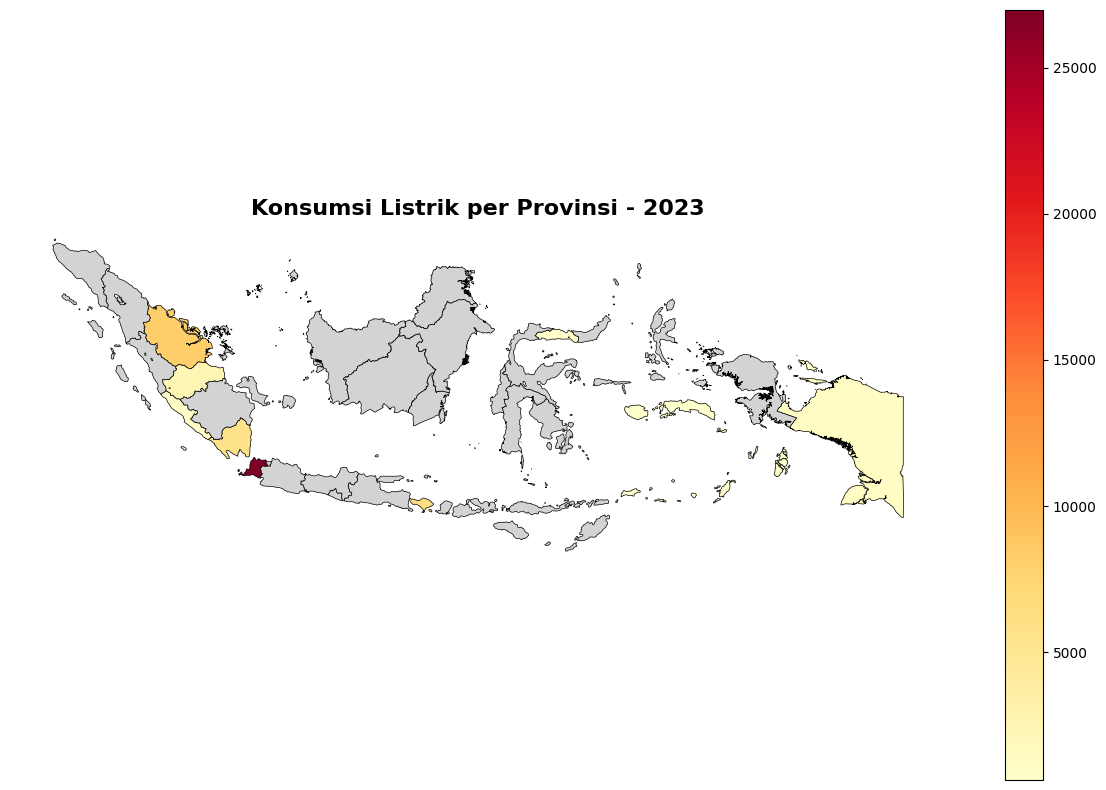


✅ Map visualization successful!


In [16]:
# Quick visualization test
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

gdf_2023.plot(
    column='Electricity_GWh',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey'}
)

ax.set_title('Konsumsi Listrik per Provinsi - 2023', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Map visualization successful!")

## 7. Save Processed Data

In [17]:
print("\n" + "="*60)
print("STEP 6: SAVING PROCESSED DATA")
print("="*60 + "\n")

# Save clean data (all years, no geo)
clean_path = PROCESSED_DIR / 'electricity_clean.csv'
df_valid.to_csv(clean_path, index=False)
print(f"💾 Saved: {clean_path}")

# Save data with geo column (for easy merging later)
geo_path = PROCESSED_DIR / 'electricity_with_geo.csv'
df_valid[['Province', 'Province_GeoJSON', 'Year', 'Electricity_GWh']].to_csv(geo_path, index=False)
print(f"💾 Saved: {geo_path}")

# Optional: Save GeoJSON dengan data 2023
geojson_out = PROCESSED_DIR / 'provinces_2023.geojson'
gdf_2023.to_file(geojson_out, driver='GeoJSON')
print(f"💾 Saved: {geojson_out}")


STEP 6: SAVING PROCESSED DATA

💾 Saved: ..\data\processed\electricity_clean.csv
💾 Saved: ..\data\processed\electricity_with_geo.csv
💾 Saved: ..\data\processed\provinces_2023.geojson


## 8. Summary Report

In [18]:
print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60 + "\n")

print("📊 Data Overview:")
print(f"   • Total raw rows: {len(df_raw)}")
print(f"   • After cleaning: {len(df_clean)}")
print(f"   • Valid for mapping: {len(df_valid)}")
print(f"   • Data removed: {len(df_raw) - len(df_valid)}")

print(f"\n📅 Years: {sorted(df_valid['Year'].unique())}")
print(f"🗺️  Provinces: {df_valid['Province'].nunique()}")

print(f"\n💾 Output files:")
print(f"   • {clean_path}")
print(f"   • {geo_path}")
print(f"   • {geojson_out}")

print("\n✅ PREPROCESSING COMPLETED!")


PREPROCESSING SUMMARY

📊 Data Overview:
   • Total raw rows: 139
   • After cleaning: 135
   • Valid for mapping: 135
   • Data removed: 4

📅 Years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
🗺️  Provinces: 34

💾 Output files:
   • ..\data\processed\electricity_clean.csv
   • ..\data\processed\electricity_with_geo.csv
   • ..\data\processed\provinces_2023.geojson

✅ PREPROCESSING COMPLETED!


## Next Steps
# 
# 1. Go to `02_eda.ipynb` for exploratory data analysis
# 2. Analyze trends, distributions, and patterns
# 3. Create visualizations